In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

### BOOSTING ALGORITHM - AdaBoost

Key Concepts:
- Initially weight each training example equally
- In each round: find weak classifier with lowest weighted error
- Increase weights of misclassified examples
- Final classifier = weighted combination of weak classifiers
- Classifier weight ∝ its accuracy

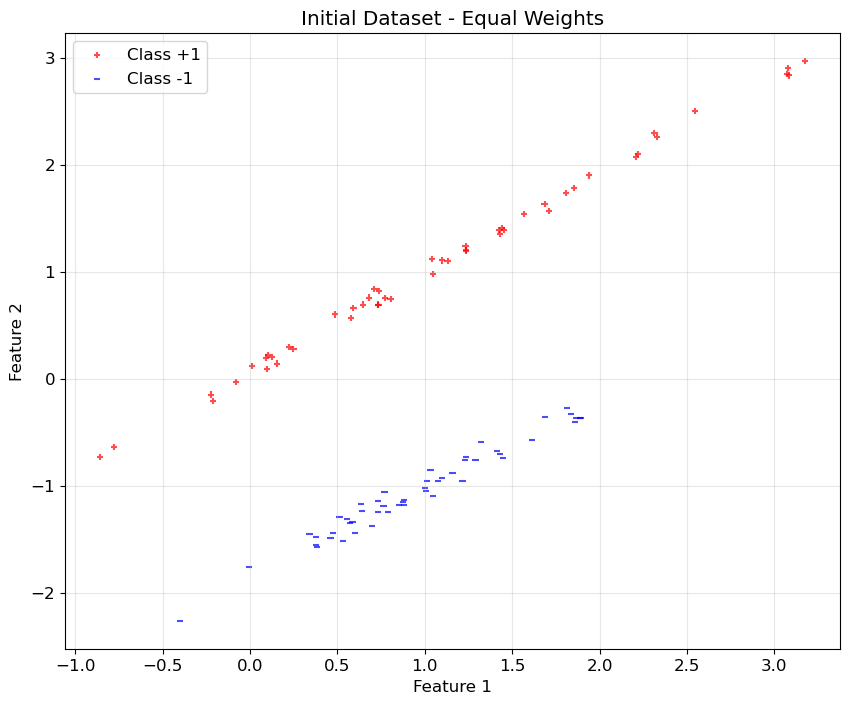

In [7]:
# Generate Sample Data
def generate_sample_data():
    """Generate a simple 2D classification dataset"""
    X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, 
                              n_informative=2, n_clusters_per_class=1,
                              random_state=42)
    # Convert from {0,1} to {-1,1} for AdaBoost convention
    y = 2 * y - 1
    return X, y

X, y = generate_sample_data()

# Plot the initial data
def plot_dataset(X, y, weights=None, title="Initial Dataset"):
    plt.figure(figsize=(10, 8))
    
    if weights is None:
        weights = np.ones(len(X)) / len(X)
    
    # Scale marker sizes based on weights
    marker_sizes = weights * 2000
    
    # Plot positive and negative classes
    plt.scatter(X[y == 1, 0], X[y == 1, 1], s=marker_sizes[y == 1], 
               c='red', marker='+', label='Class +1', alpha=0.7)
    plt.scatter(X[y == -1, 0], X[y == -1, 1], s=marker_sizes[y == -1], 
               c='blue', marker='_', label='Class -1', alpha=0.7)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_dataset(X, y, title="Initial Dataset - Equal Weights")

### ADABOOST Overview

1. INITIALIZATION:
   - All training examples start with equal weights
   - Weight = importance/size in visualization

2. EACH BOOSTING ROUND:
   - Find weak classifier with lowest weighted error
   - Increase weights of misclassified examples
   - Calculate classifier weight (alpha) based on accuracy

3. FINAL CLASSIFIER:
   - Linear combination of all weak classifiers
   - Classifier weight ∝ its accuracy
   - More accurate classifiers have more voting power

4. ADVANTAGES:
   - Can boost performance of weak learners
   - Less prone to overfitting than single strong classifiers
   - Automatic feature selection through weighting

5. IN COMPUTER VISION:
   - Used in face detection (Viola-Jones)
   - Feature selection from large feature sets
   - Combining multiple weak visual classifiers

In [8]:
# AdaBoost Implementation
class SimpleAdaBoost:
    """Simplified AdaBoost implementation"""    
    def __init__(self, n_estimators=3):
        self.n_estimators = n_estimators
        self.alphas = []  # Classifier weights
        self.classifiers = []  # Weak classifiers
        self.errors = []  # Weighted errors
        
    def fit(self, X, y):
        n_samples = X.shape[0]
        
        # Initialize weights equally
        weights = np.ones(n_samples) / n_samples
        self.weights_history = [weights.copy()]
        
        for t in range(self.n_estimators):
            print(f"\n--- Round {t+1} ---")
            print(f"Current weights: {weights[:5]}...")  # Show first 5 weights
            
            # Create and fit weak classifier (decision stump)
            classifier = DecisionTreeClassifier(max_depth=1)
            classifier.fit(X, y, sample_weight=weights)
            
            # Make predictions
            predictions = classifier.predict(X)
            
            # Calculate weighted error
            incorrect = (predictions != y)
            error = np.sum(weights[incorrect])
            
            # Avoid division by zero
            if error >= 1 - 1e-10:
                error = 1 - 1e-10
            if error <= 1e-10:
                error = 1e-10
                
            # Calculate classifier weight
            alpha = 0.5 * np.log((1 - error) / error)
            
            # Update weights
            weights *= np.exp(-alpha * y * predictions)
            weights /= np.sum(weights)  # Normalize
            
            # Store results
            self.alphas.append(alpha)
            self.classifiers.append(classifier)
            self.errors.append(error)
            self.weights_history.append(weights.copy())
            
            print(f"Weighted error: {error:.4f}")
            print(f"Classifier weight (alpha): {alpha:.4f}")
            
            # Plot current state
            self._plot_round(X, y, t+1, classifier, weights)
    
    def _plot_round(self, X, y, round_num, classifier, weights):
        """Plot the current boosting round"""
        plt.figure(figsize=(12, 10))
        
        # Create mesh for decision boundary
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                           np.linspace(y_min, y_max, 200))
        
        # Plot decision boundary
        Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
        
        # Scale marker sizes based on weights
        marker_sizes = weights * 2000
        
        # Plot data points
        plt.scatter(X[y == 1, 0], X[y == 1, 1], s=marker_sizes[y == 1], 
                   c='red', marker='+', label='Class +1', alpha=0.7)
        plt.scatter(X[y == -1, 0], X[y == -1, 1], s=marker_sizes[y == -1], 
                   c='blue', marker='_', label='Class -1', alpha=0.7)
        
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title(f'Boosting - Round {round_num}\n'
                 f'Error: {self.errors[-1]:.3f}, Alpha: {self.alphas[-1]:.3f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def predict(self, X):
        """Make predictions using all weak classifiers"""
        predictions = np.zeros(X.shape[0])
        for alpha, classifier in zip(self.alphas, self.classifiers):
            predictions += alpha * classifier.predict(X)
        return np.sign(predictions)
    
    def staged_predict(self, X):
        """Make predictions after each boosting round"""
        predictions = np.zeros(X.shape[0])
        for i, (alpha, classifier) in enumerate(zip(self.alphas, self.classifiers)):
            predictions += alpha * classifier.predict(X)
            yield np.sign(predictions)

IMPLEMENTING ADABOOST STEP BY STEP

--- Round 1 ---
Current weights: [0.01 0.01 0.01 0.01 0.01]...
Weighted error: 0.0200
Classifier weight (alpha): 1.9459


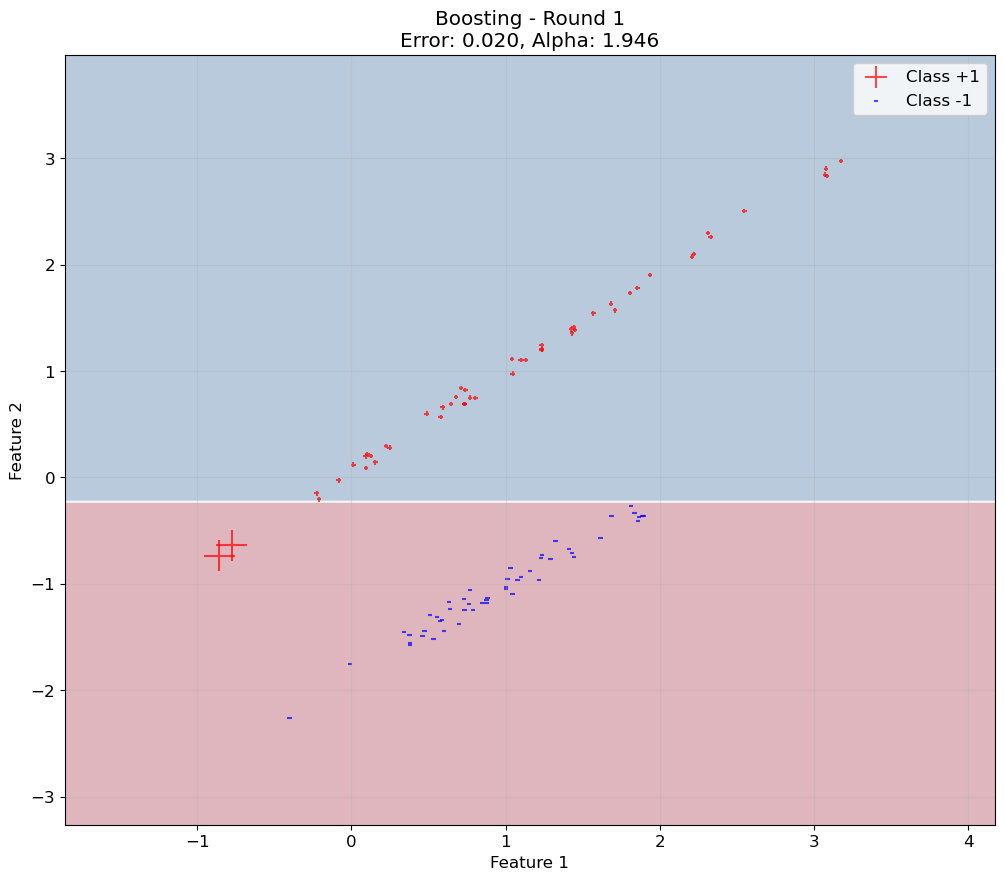


--- Round 2 ---
Current weights: [0.00510204 0.00510204 0.00510204 0.00510204 0.00510204]...
Weighted error: 0.0612
Classifier weight (alpha): 1.3650


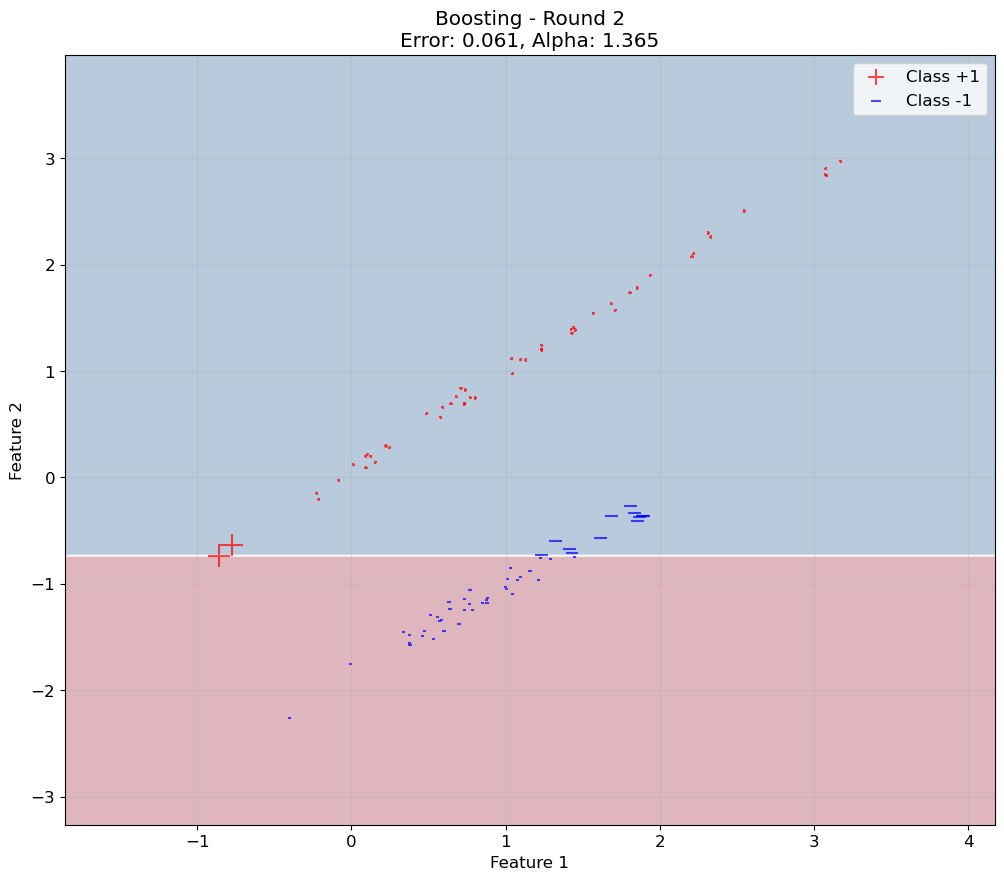


--- Round 3 ---
Current weights: [0.00271739 0.00271739 0.00271739 0.00271739 0.00271739]...
Weighted error: 0.1060
Classifier weight (alpha): 1.0662


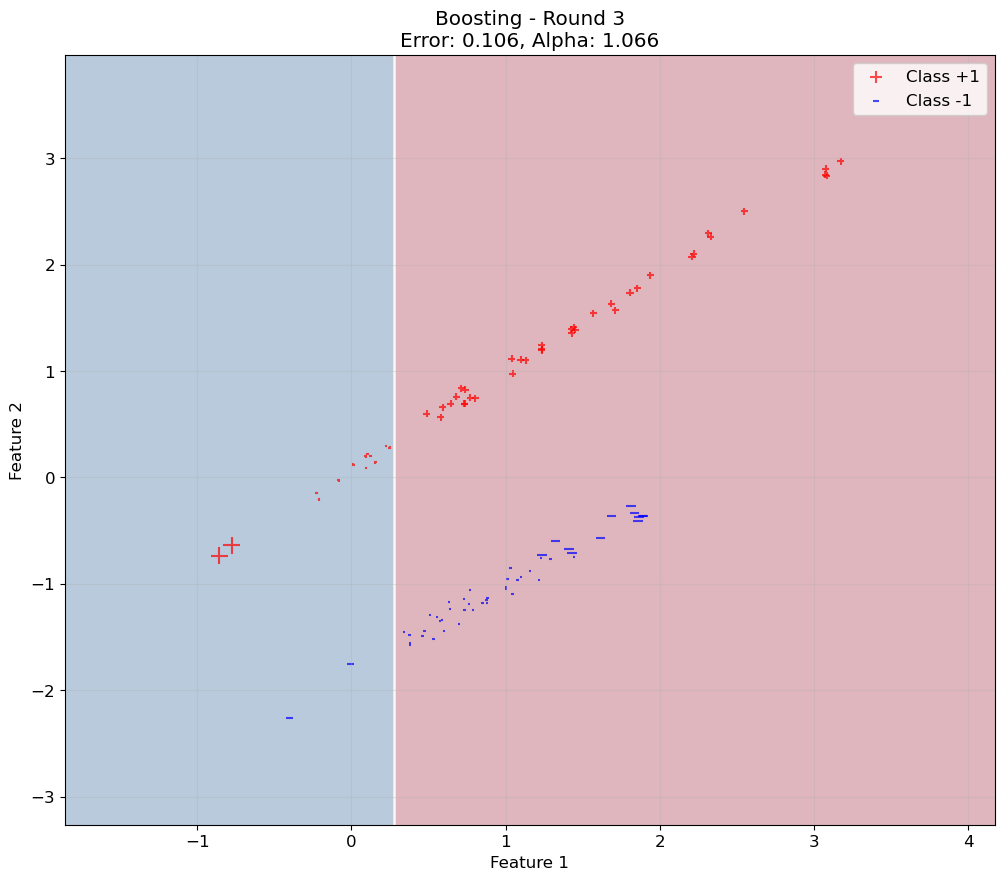

In [9]:
# Run AdaBoost Step by Step
print("IMPLEMENTING ADABOOST STEP BY STEP")
print("=" * 50)

# Initialize and fit AdaBoost
adaboost = SimpleAdaBoost(n_estimators=3)
adaboost.fit(X, y)

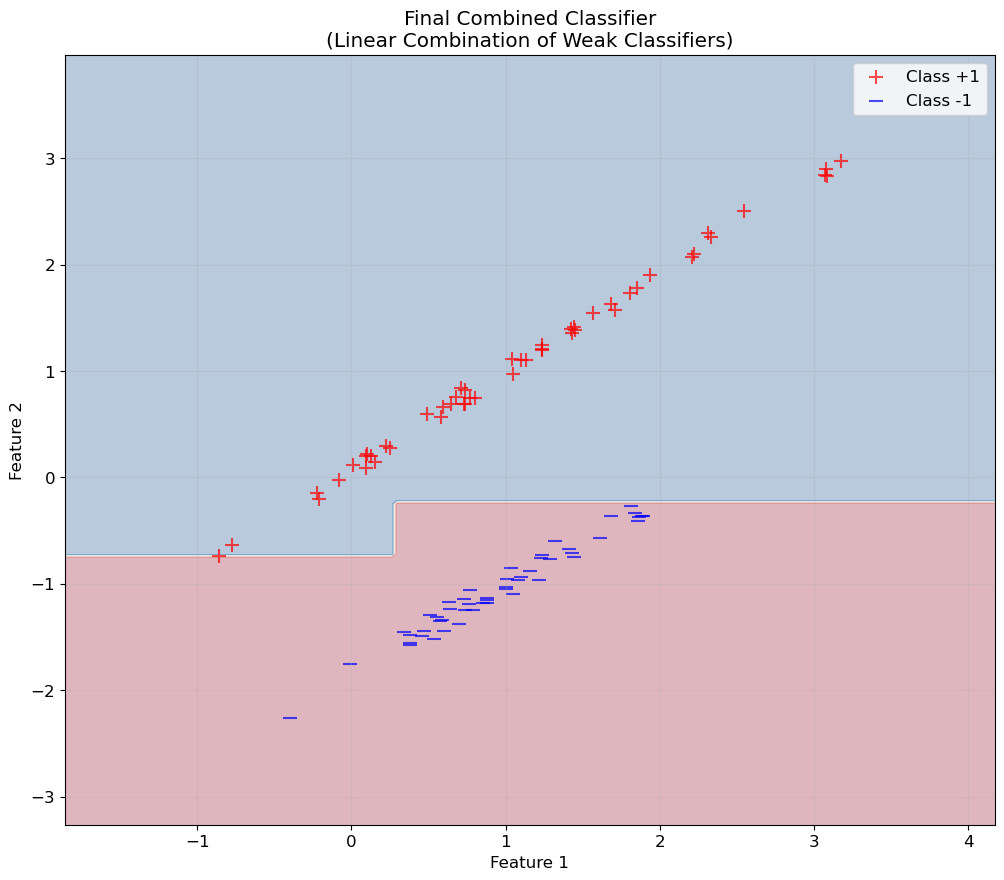

In [13]:
# Final Combined Classifier
def plot_final_classifier(adaboost, X, y):
    """Plot the final combined classifier"""
    plt.figure(figsize=(12, 10))
    
    # Create mesh for decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                       np.linspace(y_min, y_max, 200))
    
    # Get final predictions
    Z = adaboost.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
    
    # Plot data points
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', marker='+', 
               s=100, label='Class +1', alpha=0.7)
    plt.scatter(X[y == -1, 0], X[y == -1, 1], c='blue', marker='_', 
               s=100, label='Class -1', alpha=0.7)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Final Combined Classifier\n(Linear Combination of Weak Classifiers)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_final_classifier(adaboost, X, y)

In [16]:
# Compare with Scikit-learn Implementation
print("\nCOMPARISON WITH SCIKIT-LEARN ADABOOST")
print("=" * 50)

# Use scikit-learn's AdaBoost
sklearn_adaboost = AdaBoostClassifier(n_estimators=3, random_state=42)
sklearn_adaboost.fit(X, y)

# Compare predictions
our_predictions = adaboost.predict(X)
sklearn_predictions = sklearn_adaboost.predict(X)

our_accuracy = accuracy_score(y, our_predictions)
sklearn_accuracy = accuracy_score(y, sklearn_predictions)

print(f"Our implementation accuracy: {our_accuracy:.4f}")
print(f"Scikit-learn accuracy: {sklearn_accuracy:.4f}")
print(f"Agreement between implementations: {np.mean(our_predictions == sklearn_predictions):.4f}")

# Compare classifier weights
print("\nClassifier Weights Comparison:")
print("Our alphas:", [f"{alpha:.4f}" for alpha in adaboost.alphas])
print("SKLearn alphas:", [f"{alpha:.4f}" for alpha in sklearn_adaboost.estimator_weights_])


COMPARISON WITH SCIKIT-LEARN ADABOOST
Our implementation accuracy: 1.0000
Scikit-learn accuracy: 1.0000
Agreement between implementations: 1.0000

Classifier Weights Comparison:
Our alphas: ['1.9459', '1.3650', '1.0662']
SKLearn alphas: ['1.0000', '1.0000', '1.0000']
